#  Notebook 5: Introduction to  Logistic Regression, Pandas, and TensorFlow #


In [3]:
# Importing the SUSY Data set
import sys, os
import pandas as pd
#import matplotlib as plt
import numpy as np
import warnings
#Commnet the next line on to turn off warnings
#warnings.filterwarnings('ignore')


seed=123
np.random.seed(seed)
import tensorflow as tf
# suppress tflow compilation warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

tf.random.set_seed(seed)

# Download the SUSY.csv (about 2GB) from UCI ML archive and save it in the same directory as this jupyter notebook
# See: https://archive.ics.uci.edu/ml/datasets/SUSY#
filename="SUSY.csv"
#filename=os.path.expanduser('~')+'/ML_review/SUSY_data/SUSY.csv' 

columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

# Load 1,500,000 rows as train data, 50,000 as test data
df_train=pd.read_csv(filename,names=columns,nrows=1500000,engine='python')
df_test=pd.read_csv(filename,names=columns,nrows=50000, skiprows=1500000,engine='python')

In [4]:
# take a look a the data
print(df_test.head(5))

   signal  lepton 1 pT  lepton 1 eta  lepton 1 phi  lepton 2 pT  lepton 2 eta   
0     0.0     0.447252      0.742929     -0.968643     0.632259      0.060092  \
1     0.0     0.511997     -1.549286      0.445136     0.447759     -1.596736   
2     0.0     1.157666     -0.583426     -0.859824     1.501585     -0.224248   
3     1.0     1.033339     -1.220178      0.138178     0.645071      0.348810   
4     0.0     0.604274      0.015543     -0.303150     0.834504     -0.159172   

   lepton 2 phi  missing energy magnitude  missing energy phi   MET_rel   
0      0.719435                  0.244449           -0.587432  0.230029  \
1      0.737621                  0.171184            1.220191  0.195229   
2      1.417488                  0.745768           -1.149379  0.573364   
3     -1.638817                  0.737359            0.226995  0.164100   
4      1.158237                  0.343184            1.572977  0.309608   

   axial MET       M_R    M_TR_2         R       MT2       S_R

In [5]:
df_test.mean()

signal                      0.456620
lepton 1 pT                 1.002352
lepton 1 eta               -0.002501
lepton 1 phi                0.002411
lepton 2 pT                 1.000302
lepton 2 eta               -0.002059
lepton 2 phi               -0.000010
missing energy magnitude    1.001581
missing energy phi         -0.003718
MET_rel                     1.004298
axial MET                   0.001233
M_R                         1.000532
M_TR_2                      1.001271
R                           1.001678
MT2                         0.999446
S_R                         0.999967
M_Delta_R                   0.998658
dPhi_r_b                    1.002790
cos(theta_r1)               0.225199
dtype: float64

In [6]:
df_test.std()

signal                      0.498120
lepton 1 pT                 0.696086
lepton 1 eta                1.003268
lepton 1 phi                1.001319
lepton 2 pT                 0.660701
lepton 2 eta                1.001371
lepton 2 phi                0.999298
missing energy magnitude    0.879445
missing energy phi          1.003257
MET_rel                     0.890714
axial MET                   1.007772
M_R                         0.634308
M_TR_2                      0.583197
R                           0.470992
MT2                         0.856735
S_R                         0.625473
M_Delta_R                   0.622620
dPhi_r_b                    0.434804
cos(theta_r1)               0.197136
dtype: float64

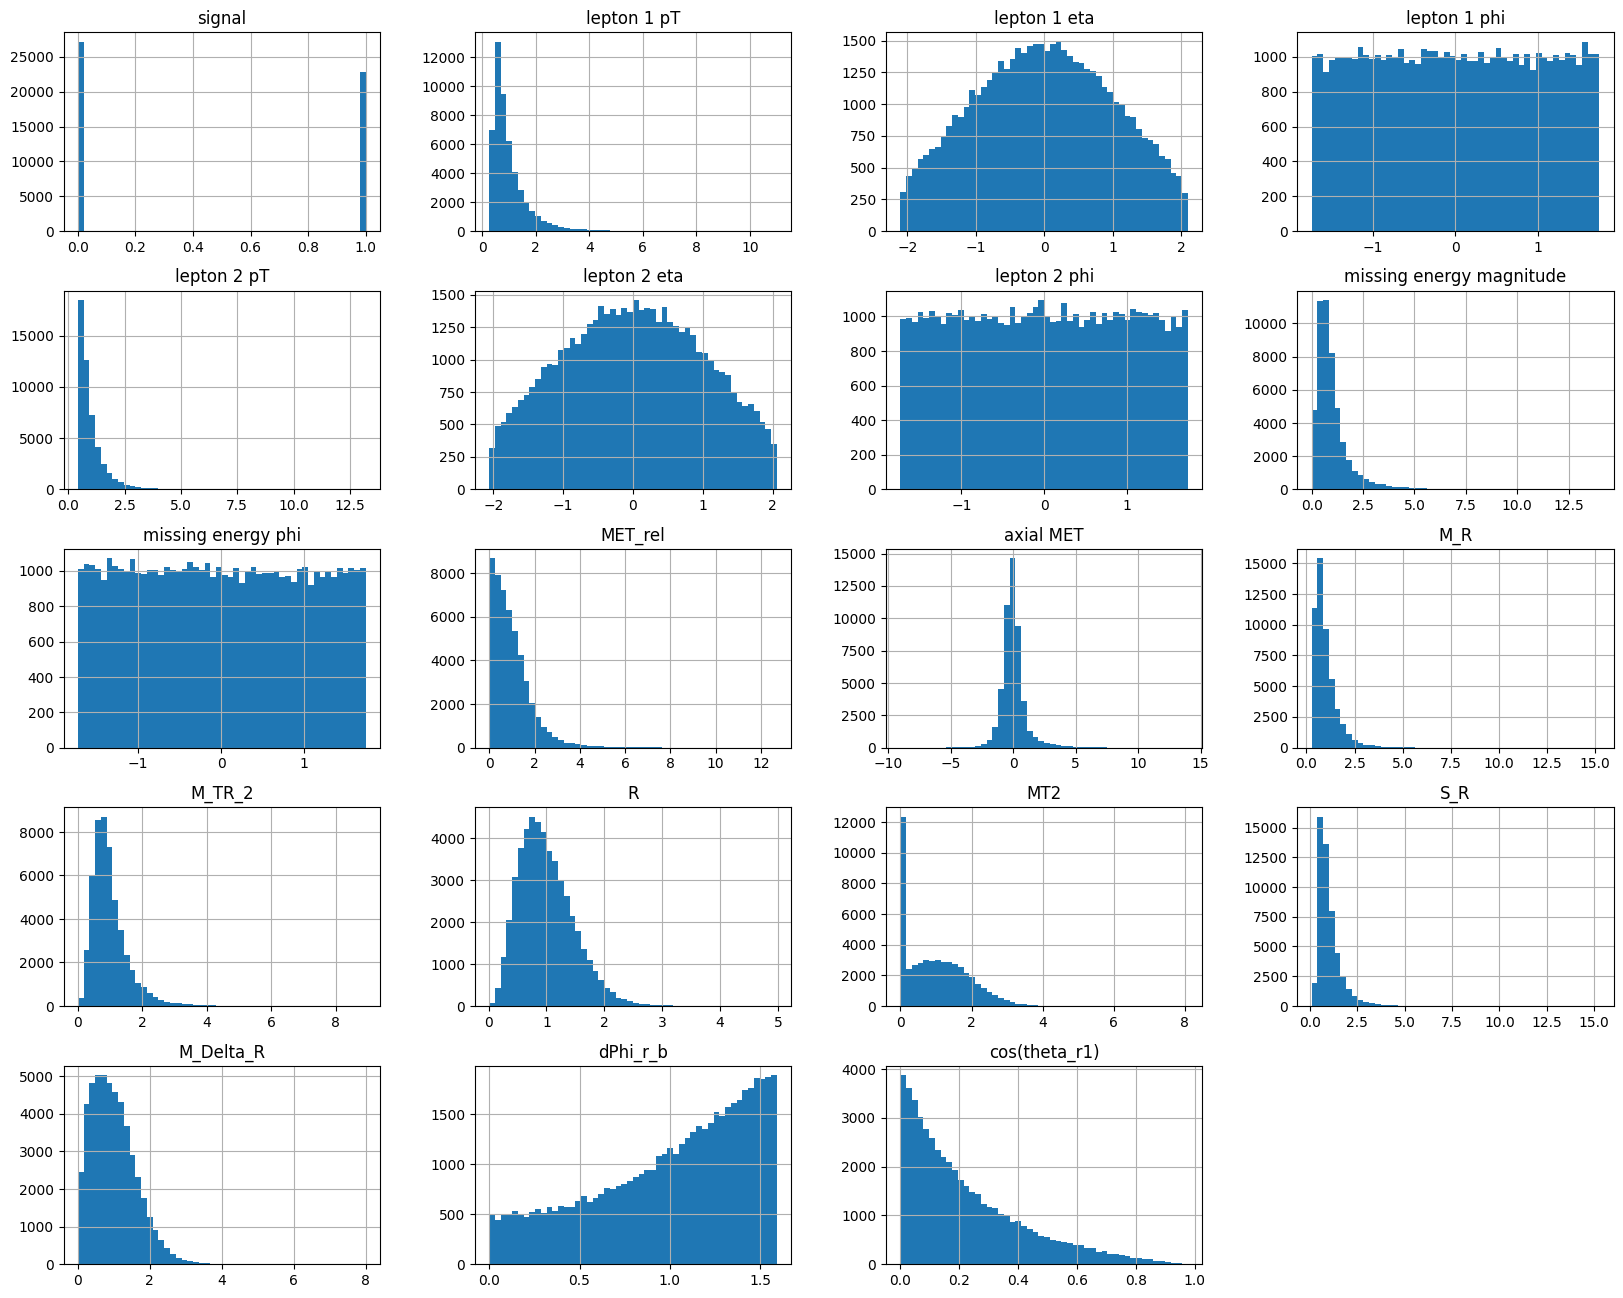

In [7]:
ax = df_test.hist(figsize=(20, 16), bins=50)

In [8]:
df_test.groupby(['signal']).mean()

,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
signal,,,,,,,,,,,,,,,,,,
0.0,0.754458,-0.004033,0.003264,0.882888,-0.003986,0.004607,0.651472,0.000132,0.774523,-0.070761,0.845722,0.775207,0.955254,0.940545,0.852394,0.846599,0.993003,0.176027
1.0,1.297348,-0.000677,0.001396,1.140025,0.000234,-0.005504,1.418212,-0.008298,1.277733,0.086907,1.184756,1.270288,1.056922,1.069539,1.175580,1.179609,1.014437,0.283715


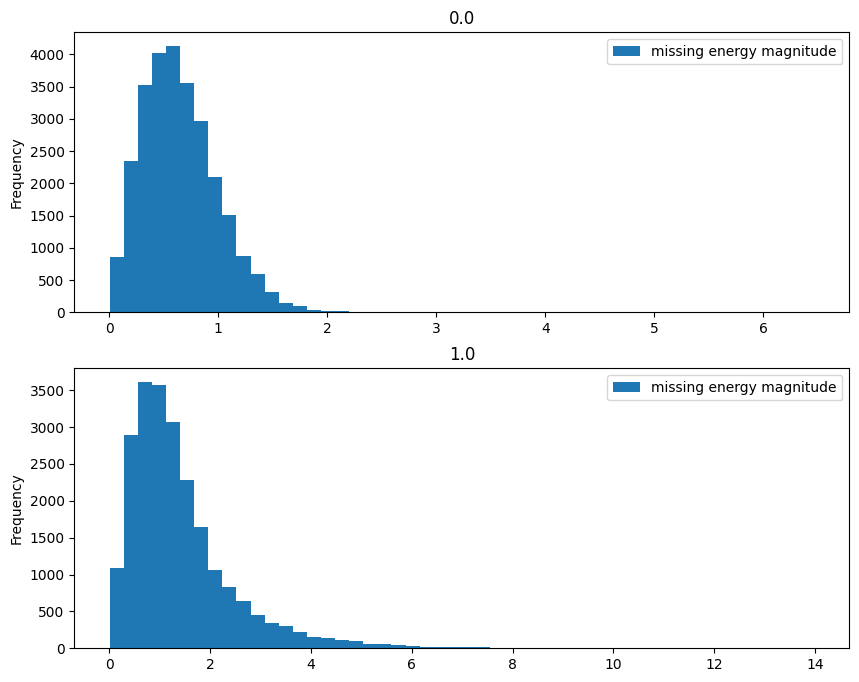

In [11]:
ax = df_test.plot.hist(figsize=(10, 8), bins=50, column=["missing energy magnitude"], by="signal")

## Run logistic regression using Linear Model functions in TensorFlow ##

Let us define some functions to do the actual training for us and will let them take the number of features as an input parameter.


In [12]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
#import ml_style as style #optional styling sheet
#mpl.rcParams.update(style.style) #optional styling sheet

def getTrainData(nVar):
    designMatrix = df_train.iloc[:,1:nVar+1].values
    #now the signal
    labels = df_train['signal'].values # labels (0 or 1)
    return (designMatrix,labels)

def getTestData(nVar):
    designMatrix = df_test.iloc[:,1:nVar+1].values
    #now the signal
    labels = df_test['signal'].values
    return (designMatrix,labels)

# define
def build_roc_curve(probs, signal_bit, threshes):
    # Convert things to a pandas series to build a DataFrame
    # which will make ROC curve logic easier to express
    signal_probs = pd.Series(probs[:,1])
    signal_true = pd.Series(signal_bit)
    signal_df = pd.DataFrame(signal_probs, columns=['sig_prob'])
    signal_df.loc[:,'sig_true'] = signal_true
    Acceptance = []
    Rejection = []
    for thresh in threshes:
        # define acceptance
        signal_df.loc[:,'accept'] = signal_df['sig_prob'] > thresh
        # sum over data frame with slicing conditions
        nSigCor = len(signal_df[(signal_df['accept']) & (signal_df['sig_true']==1.)])
        nSig = len(signal_df[signal_df['sig_true']==1.])
        nBkgCor = len(signal_df[ (signal_df['sig_true']==0.) & (~signal_df['accept'])])
        nBkg = len(signal_df[signal_df['sig_true']==0.])
        Acceptance.append(nSigCor/nSig) # False positive rate
        Rejection.append(nBkgCor/nBkg) # True positive rate

    return Acceptance, Rejection
    
# let's define this as a function so we can call it easily
def runTensorFlowRegression(nVar,alpha):

    #make data array placeholder for just first 8 simple features
    tf.compat.v1.disable_eager_execution() 
    x = tf.compat.v1.placeholder(tf.float32,[None,nVar])
    #make weights and bias
    W = tf.Variable(tf.zeros([nVar,2])) #we will make y 'onehot' 0 bit is bkg, 1 bit is signal
    b = tf.Variable(tf.zeros([2]))

    #make 'answer variable'
    y = tf.nn.softmax(tf.matmul(x, W) + b)
    #placeholder for correct answer
    y_ = tf.compat.v1.placeholder(tf.float32, [None, 2])
    #cross entropy with L2 regularizer
    cross_entropy = tf.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(logits=y,labels=y_)+alpha*tf.nn.l2_loss(W))
    
    #define training step
    train_step = tf.compat.v1.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    #initialize variables 
    init = tf.compat.v1.global_variables_initializer()
    #setup session
    sess = tf.compat.v1.Session()
    sess.run(init)

    #ok now everything is setup for tensorflow, but we need the data in a useful form
    #first let's get the variables
    Var_train, Sig_train_bit1 = getTrainData(nVar)
    #now the signal
    Sig_train_bit0 = Sig_train_bit1.copy()
    Sig_train_bit0 = 1 - Sig_train_bit0
    Sig_train = np.column_stack((Sig_train_bit0,Sig_train_bit1))
    
    ######## ------- TRAINING ----------############
    #Now perform minibatch gradient descent with minibatches of size 1000:
    n_data = len(Sig_train_bit1)
    minibatch_size = 1000
    n_minibatch = n_data//minibatch_size
    print('\t Training with %i minibatches, dataset size is %i'%(n_minibatch,n_data))
    for i in range(0, n_minibatch):
        sys.stdout.write("%.3f %% completed \r"%(100*i/n_minibatch))
        sys.stdout.flush()
        start = i*minibatch_size
        end = (i+1)*minibatch_size-1
        
        batch_x = Var_train[start:end]
        batch_y = Sig_train[start:end]
        sess.run(train_step, feed_dict={x: batch_x, y_: batch_y})
    
    
    # Accuracy function:
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    ######## ------- TESTING ----------############
    # Setup test data
    Var_test = df_test.iloc[:,1:nVar+1].values
    
    # Now the signal
    Sig_test_bit1 = df_test['signal'].values
    
    Sig_test_bit0 = Sig_test_bit1.copy()
    Sig_test_bit0 = 1 - Sig_test_bit0
    Sig_test = np.column_stack((Sig_test_bit0,Sig_test_bit1))
    print("\t Accuracy for alpha %.1E : %.3f" %(alpha,sess.run(accuracy, feed_dict={x: Var_test, y_: Sig_test})))
    
    # Get the weights
    weights = W.eval(session=sess)
    print("\t Weight vector")
    print(weights)
    # Get probabilities assigned (i.e. evaluate y on test data)
    probs = y.eval(feed_dict = {x: Var_test}, session = sess)
    # now let's get the signal efficiency and background rejection on the test data
    print('\t Computing ROC curve ...')
    # build ROC curve by scanning over thresholds of probability of being
    # a background event and calculating signal efficiency/background rejection
    # at each threshold
    threshes = np.arange(0,1,0.01)
    Acceptance, Rejection = build_roc_curve(probs, Sig_test_bit1, threshes)

    return (probs,Acceptance,Rejection)

# Training and evaluating model
Now let's run using the first 8 variables only (the low-level features). Note: this will take several minutes !

Training for alpha = 1.00E-10
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-10 : 0.770
	 Weight vector
[[-2.3664563   2.3664563 ]
 [ 0.01083269 -0.0108327 ]
 [ 0.0111784  -0.01117842]
 [ 0.4874078  -0.48740783]
 [-0.00451729  0.00451728]
 [ 0.00817029 -0.00817029]
 [-1.8409445   1.8409442 ]
 [ 0.01455619 -0.01455619]]
	 Computing ROC curve ...
Training for alpha = 7.94E-10
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 7.9E-10 : 0.770
	 Weight vector
[[-2.3664558   2.3664558 ]
 [ 0.01083269 -0.01083271]
 [ 0.01117839 -0.01117843]
 [ 0.48740742 -0.48740724]
 [-0.00451729  0.00451728]
 [ 0.00817028 -0.00817029]
 [-1.8409444   1.8409444 ]
 [ 0.01455619 -0.01455619]]
	 Computing ROC curve ...
Training for alpha = 6.31E-09
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 6.3E-09 : 0.770
	 Weight vector
[[-2.366453    2.366453  ]
 [ 0.01083268 -0.01083271]
 [ 0.01117842 -0.01117838]
 [ 0.48740

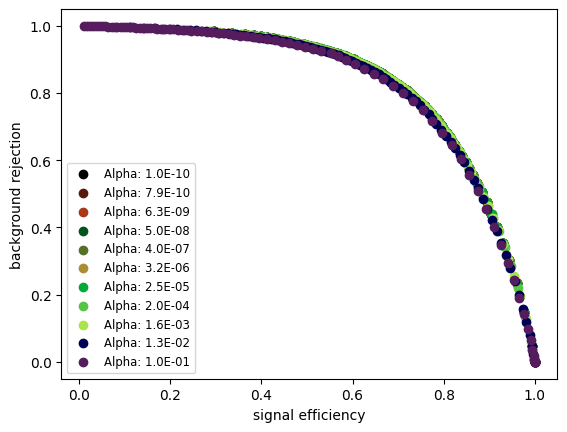

In [13]:
# We sweep the L2 regularizer strength (alpha) over 10 decades
alphas = np.logspace(-10,-1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    print("Training for alpha = %.2E"%alpha)
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probsSimple,accep,rej = runTensorFlowRegression(8,alpha)
    ax.scatter(accep,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1
    
ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-05 : 0.770
	 Weight vector
[[-2.3609037   2.3609035 ]
 [ 0.01082194 -0.01082194]
 [ 0.01116721 -0.01116718]
 [ 0.48414114 -0.48414117]
 [-0.00447855  0.00447855]
 [ 0.00815122 -0.00815121]
 [-1.8387759   1.8387758 ]
 [ 0.0145428  -0.01454284]]
	 Computing ROC curve ...


<Axes: ylabel='Frequency'>

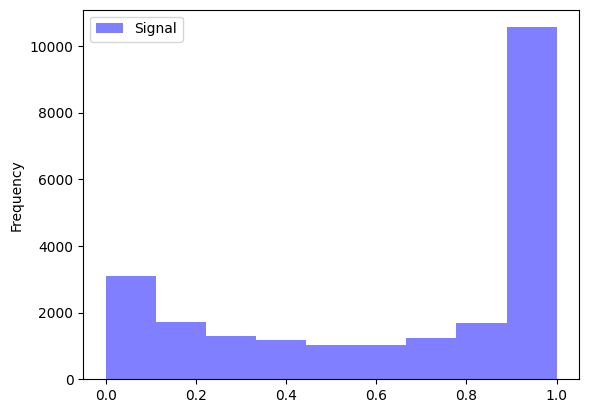

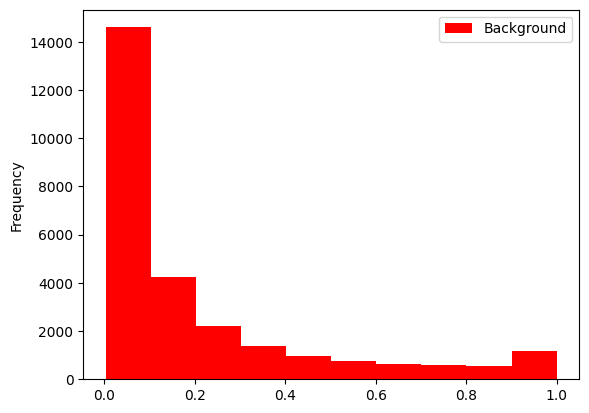

In [14]:
# now let's investigate how mixed the events are
probsSimple,accep,rej = runTensorFlowRegression(8,.00001) # train the model for 8 variables and alpha=.00001
Signal = df_test['signal'].values

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-01 : 0.736
	 Weight vector
[[-0.30417112  0.30417112]
 [ 0.0005564  -0.0005564 ]
 [ 0.01109445 -0.01109445]
 [-0.11113968  0.11113968]
 [ 0.00223698 -0.00223698]
 [-0.00278508  0.00278509]
 [-0.40263423  0.40263423]
 [ 0.00784159 -0.00784159]]
	 Computing ROC curve ...


<Axes: ylabel='Frequency'>

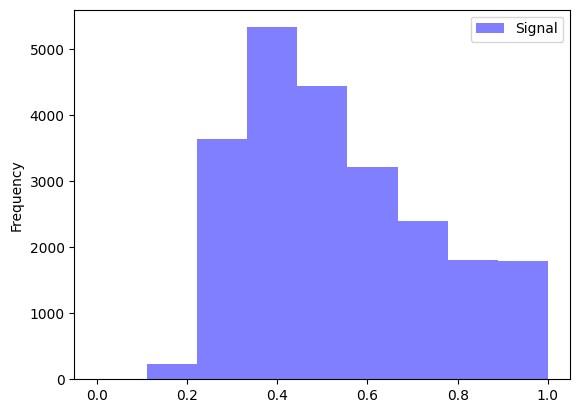

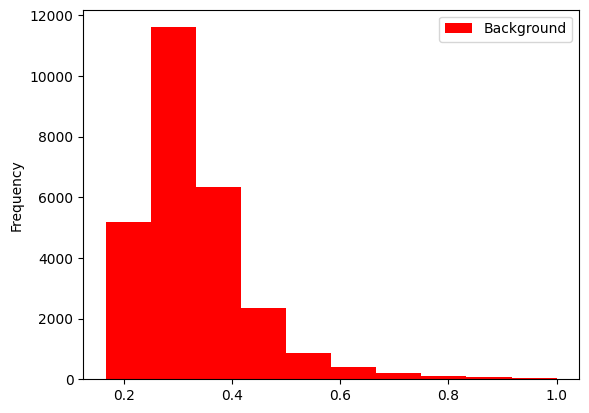

In [15]:
# now let's investigate how mixed the events are
probsSimple,accep,rej = runTensorFlowRegression(8,.1) # train the model for 8 variables and alpha=.1
Signal = df_test['signal'].values

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

### Now let's try to train the same model using the full set of 18 features:

	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-10 : 0.788
	 Weight vector
[[-1.7055491   1.7055491 ]
 [ 0.01212878 -0.01212877]
 [ 0.00882375 -0.00882375]
 [-0.08921197  0.08921191]
 [-0.00443676  0.00443675]
 [ 0.00296732 -0.00296734]
 [-2.8729284   2.8729284 ]
 [ 0.01080222 -0.01080222]
 [ 0.00623431 -0.00623441]
 [-0.52379864  0.5237985 ]
 [ 0.51494384 -0.514944  ]
 [-1.2056322   1.2056324 ]
 [ 0.9633036  -0.9633036 ]
 [ 0.41670796 -0.4167077 ]
 [ 0.7846477  -0.7846476 ]
 [-0.35774842  0.3577485 ]
 [ 1.2321442  -1.232144  ]
 [-0.48902723  0.48902732]]
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 7.9E-10 : 0.788
	 Weight vector
[[-1.7055491   1.7055489 ]
 [ 0.01212879 -0.01212877]
 [ 0.00882376 -0.00882374]
 [-0.08921194  0.08921191]
 [-0.00443677  0.00443674]
 [ 0.00296731 -0.00296734]
 [-2.872928    2.8729274 ]
 [ 0.01080222 -0.01080223]
 [ 0.00623441 -0.00623421]
 [-0.52379835  0.52379

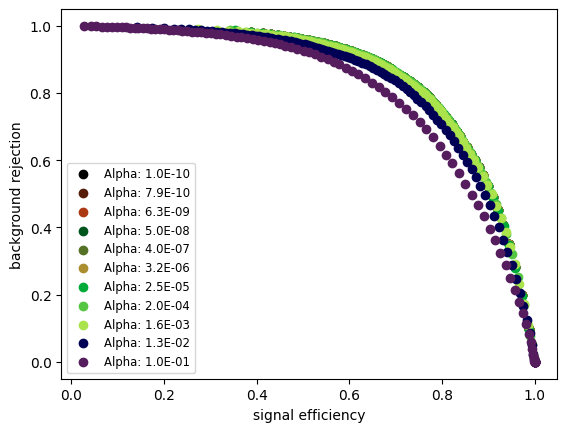

In [26]:
alphas = np.logspace(-10,-1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probsSimple,accep,rej = runTensorFlowRegression(18,alpha)
    ax.scatter(accep,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1
    
ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-05 : 0.788
[[-1.7010735   1.7010733 ]
 [ 0.01212083 -0.01212082]
 [ 0.00882096 -0.00882094]
 [-0.0890386   0.08903858]
 [-0.00441552  0.00441553]
 [ 0.00297656 -0.00297657]
 [-2.8629432   2.8629425 ]
 [ 0.01079255 -0.01079256]
 [ 0.00598628 -0.00598616]
 [-0.52318966  0.5231896 ]
 [ 0.51204574 -0.5120456 ]
 [-1.2017683   1.2017688 ]
 [ 0.9583153  -0.95831525]
 [ 0.41524932 -0.4152493 ]
 [ 0.7812358  -0.78123564]
 [-0.35729158  0.35729176]
 [ 1.2275256  -1.2275254 ]
 [-0.48801053  0.4880106 ]]
	 Computing ROC curve ...


<Axes: ylabel='Frequency'>

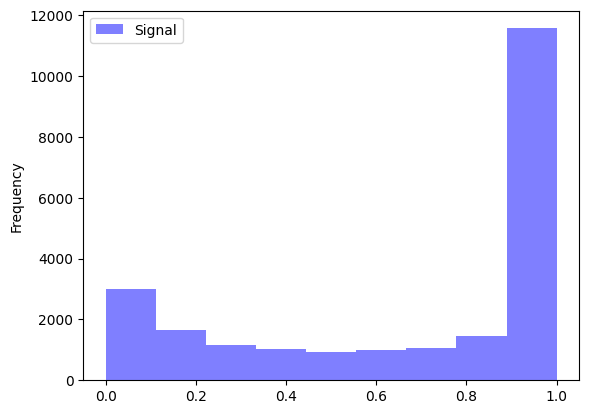

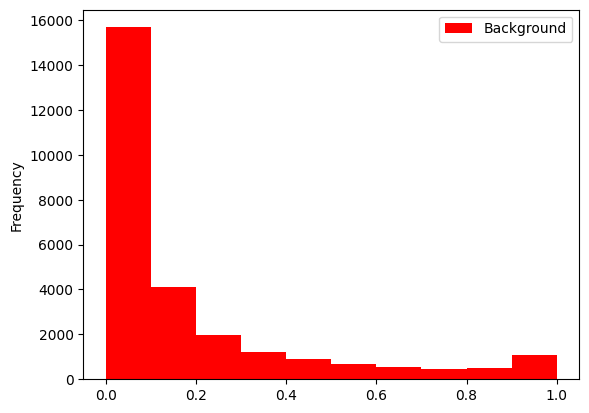

In [19]:
# now let's investigate how mixed the events are
probsSimple,accep,rej = runTensorFlowRegression(18,.00001) # train the model for 8 variables and alpha=.00001
Signal = df_test['signal'].values

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-01 : 0.744
	 Weight vector
[[-0.24660665  0.24660663]
 [-0.00068915  0.00068915]
 [ 0.01057352 -0.01057352]
 [-0.08401603  0.08401603]
 [ 0.00313334 -0.00313334]
 [-0.00264121  0.0026412 ]
 [-0.30584618  0.3058462 ]
 [ 0.00677844 -0.00677844]
 [-0.1248439   0.1248439 ]
 [-0.11012906  0.11012906]
 [-0.10569943  0.10569943]
 [-0.1882095   0.18820952]
 [-0.03063747  0.03063747]
 [ 0.00077786 -0.00077786]
 [-0.0842088   0.0842088 ]
 [-0.10220502  0.10220502]
 [ 0.03149346 -0.03149346]
 [-0.06566094  0.06566093]]
	 Computing ROC curve ...


<Axes: ylabel='Frequency'>

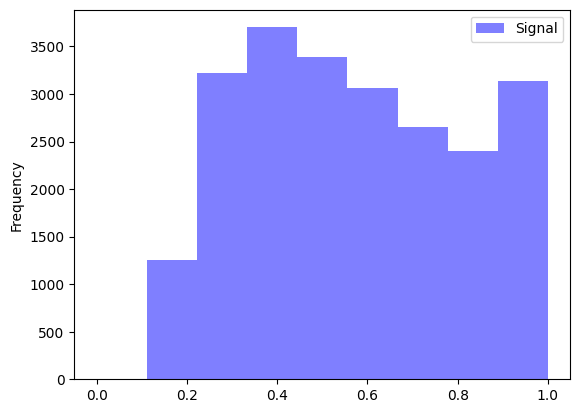

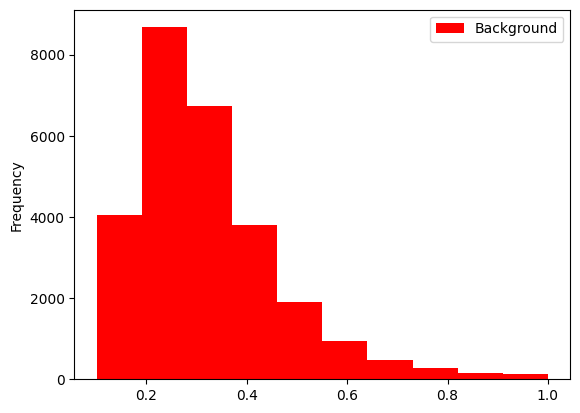

In [25]:
# now let's investigate how mixed the events are
probsSimple,accep,rej = runTensorFlowRegression(18,.1) # train the model for 8 variables and alpha=.1
Signal = df_test['signal'].values

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')